# Import : by GitHub

You can try this code in Colab by this method.  

In [ ]:
!git clone https://github.com/KanghwaSisters/24_2_mainSession.git

Cloning into '24_2_mainSession'...
remote: Enumerating objects: 288, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 288 (delta 81), reused 67 (delta 40), pack-reused 148 (from 1)
Receiving objects: 100% (288/288), 1.29 MiB | 3.37 MiB/s, done.
Resolving deltas: 100% (123/123), done.


In [ ]:
import os
os.chdir('/content/24_2_mainSession/4주차/env')

In [ ]:
! python GridWorldEnvironment.py

In [ ]:
from GridWorldEnvironment import GridWorldEnvironment

In [ ]:
import os
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#DQN Class

In [ ]:
# DQN 인공신경망
class DQN(nn.Module):
    def __init__(self, in_features, out_features):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(in_features, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc_out = nn.Linear(24, out_features)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        q = self.fc_out(x)
        return q

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# 카트폴 예제에서의 DQN 에이전트
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.render = False
        # 상태와 행동의 크기 정의
        self.action_size = action_size
        self.state_size = state_size

        # DQN 하이퍼파라미터
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000

        # 리플레이 메모리, 최대 크기 2000
        self.memory = deque(maxlen=2000)

        # 모델과 타깃 모델 생성
        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

        # 타깃 모델 초기화
        self.update_target_model()

    # 타깃 모델을 모델의 가중치로 업데이트
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    # 입실론 탐욕 정책으로 행동 선택
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            state = torch.tensor(state, dtype=torch.float32)
            q_value = self.model(state)
            return torch.argmax(q_value).item()

    # 샘플 <s, a, r, s'>을 리플레이 메모리에 저장
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # 리플레이 메모리에서 무작위로 추출한 배치로 모델 학습
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # 메모리에서 배치 크기만큼 무작위로 샘플 추출
        mini_batch = random.sample(self.memory, self.batch_size)

        states = torch.tensor(np.array([sample[0] for sample in mini_batch]), dtype=torch.float32).reshape(self.batch_size, -1) #64,4
        actions = torch.tensor(np.array([sample[1] for sample in mini_batch]), dtype=torch.long) # 64,
        rewards = torch.tensor(np.array([sample[2] for sample in mini_batch]), dtype=torch.float32) # 64,
        next_states = torch.tensor(np.array([sample[3] for sample in mini_batch]), dtype=torch.float32).reshape(self.batch_size, -1) #64,4
        dones = torch.tensor(np.array([sample[4] for sample in mini_batch]), dtype=torch.float32) # 64,
        #print(f"States shape: {states.shape}")
        #print(f"Actions shape: {actions.shape}")
        #print(f"Rewards shape: {rewards.shape}")
        #print(f"Next states shape: {next_states.shape}")
        #print(f"Dones shape: {dones.shape}")

        # 현재 상태에 대한 모델의 큐함수
        predicts = self.model(states)
        #print(f"Predicts shape: {predicts.shape}")      # (64, 2)
        #one_hot_action = F.one_hot(torch.tensor(action), self.action_size).float()
        #predicts = torch.sum(one_hot_action * predicts, dim=1)

        # 다음 상태에 대한 타깃 모델의 큐함수
        target_predicts = self.target_model(next_states)
        target_predicts = target_predicts.detach()  # gradients가 타깃 모델에 영향을 주지 않도록 detach
        #print(f"Target predicts shape: {target_predicts.shape}")  # (64, 2)

        # 벨만 최적 방정식을 이용한 업데이트 타깃
        max_q,_ = torch.max(target_predicts, dim=1)  # 다음 상태에서의 최대 Q값
        #max_q = max_q.unsqueeze(1)
        #print(f"Max Q shape: {max_q.shape}")           # (64, )
        targets = rewards + (1 - dones) * self.discount_factor * max_q
        targets = targets.unsqueeze(1)
        #print(f"Targets shape: {targets.shape}")       # (64, 1)

        mse = nn.MSELoss()
        loss = mse(predicts, targets)

        # 오류함수를 줄이는 방향으로 모델 업데이트
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [ ]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# DQN 에이전트 생성
agent = DQNAgent(state_size, action_size)

scores, episodes = [], []
score_avg = 0

num_episode = 300

episode:   0 | score avg: 24.00 | memory length:   24 | epsilon: 1.0000
episode:   1 | score avg: 23.30 | memory length:   41 | epsilon: 1.0000
episode:   2 | score avg: 22.47 | memory length:   56 | epsilon: 1.0000
episode:   3 | score avg: 21.92 | memory length:   73 | epsilon: 1.0000
episode:   4 | score avg: 22.73 | memory length:  103 | epsilon: 1.0000
episode:   5 | score avg: 21.86 | memory length:  117 | epsilon: 1.0000
episode:   6 | score avg: 22.67 | memory length:  147 | epsilon: 1.0000
episode:   7 | score avg: 21.60 | memory length:  159 | epsilon: 1.0000
episode:   8 | score avg: 20.84 | memory length:  173 | epsilon: 1.0000
episode:   9 | score avg: 20.46 | memory length:  190 | epsilon: 1.0000
episode:  10 | score avg: 21.01 | memory length:  216 | epsilon: 1.0000
episode:  11 | score avg: 21.01 | memory length:  237 | epsilon: 1.0000
episode:  12 | score avg: 23.31 | memory length:  281 | epsilon: 1.0000
episode:  13 | score avg: 23.28 | memory length:  304 | epsilon:

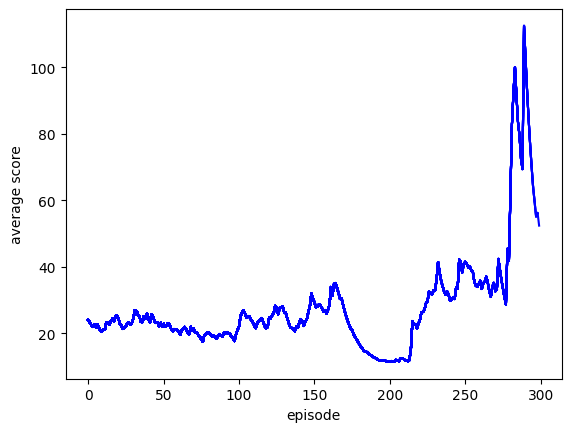

In [ ]:
for e in range(num_episode):
        done = False
        score = 0
        # env 초기화
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        while not done:
            if agent.render:
                env.render()

            # 현재 상태로 행동을 선택
            action = agent.get_action(state)
            # 선택한 행동으로 환경에서 한 타임스텝 진행
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])

            # 타임스텝마다 보상 0.1, 에피소드가 중간에 끝나면 -1 보상
            score += reward
            reward = 0.1 if not done or score == 500 else -1

            # 리플레이 메모리에 샘플 <s, a, r, s'> 저장
            agent.append_sample(state, action, reward, next_state, done)
            # 매 타임스텝마다 학습
            if len(agent.memory) >= agent.train_start:
                agent.train_model()

            state = next_state

            if done:
                # 각 에피소드마다 타깃 모델을 모델의 가중치로 업데이트
                agent.update_target_model()
                # 에피소드마다 학습 결과 출력
                score_avg = 0.9 * score_avg + 0.1 * score if score_avg != 0 else score
                print("episode: {:3d} | score avg: {:3.2f} | memory length: {:4d} | epsilon: {:.4f}".format(e, score_avg, len(agent.memory), agent.epsilon))

                # 에피소드마다 학습 결과 그래프로 저장
                scores.append(score_avg)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.xlabel("episode")
                pylab.ylabel("average score")
               # pylab.savefig("./save_graph/graph.png")

                # 이동 평균이 400 이상일 때 종료
                if score_avg > 400:
                    agent.model.save_weights("./save_model/model", save_format="tf")
                    sys.exit()